In [1]:
from result_analysis import show_all_metrics_pred, show_all_metrics_fair, show_metric_alg, show_pred_metrics, show_fair_metrics, show_metric_aggregated
from result_analysis import create_trade_off_gif
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
algorithms = ['OBNC', 'OBNC-remove-sensitive', 'OBNC-optimize-demographic-parity-0', 'OBNC-optimize-demographic-parity-0.5']

experiments = ['phishing_having_IP_Address', 'bank_housing', 'monks1_attr3', 'biodeg_V25', 
                'credit_A1', 'sick_referral_source_other', 'vote_immigration', 'ads_local', 'churn_voice_mail_plan']

noise_types = ['random', 'flip', 'bias', 'balanced_bias']

nr = [i/10 for i in range(1, 6)]

In [3]:
pred_metrics = ['accuracy', 'roc_auc']

fair_metrics = [
        'auc_difference',
        'equal_opportunity_difference', 
        'predictive_equality_difference',
        'demographic_parity_difference',
        'equalized_odds_difference']

metrics = pred_metrics + fair_metrics

In [4]:
runs = {}
for noise_type in noise_types:
    runs[noise_type] = {}
    for exp in experiments:
        for alg in algorithms:
            runs[noise_type][f'{exp}_{alg}'] = pd.read_csv(f'../noiseinjection_results/{noise_type}/{exp}_{alg}.csv').fillna(0)

# Predictive Performance

## Random noise

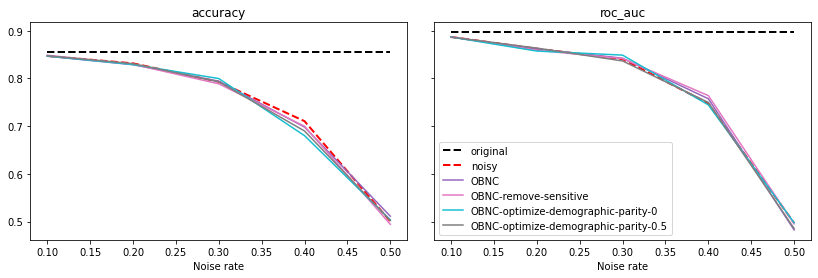

In [5]:
show_all_metrics_pred('random', 'original', algorithms, experiments, runs, nr)

## Label flipping

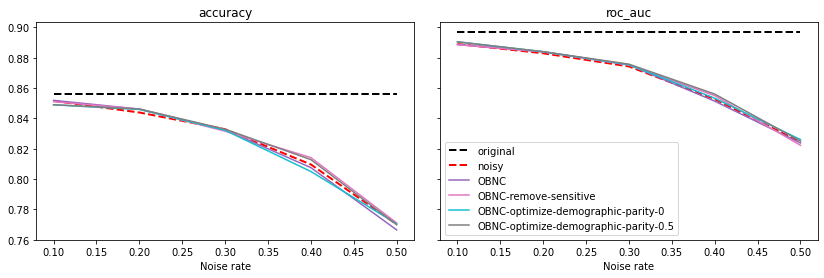

In [6]:
show_all_metrics_pred('flip', 'original', algorithms, experiments, runs, nr)

## Positive Bias

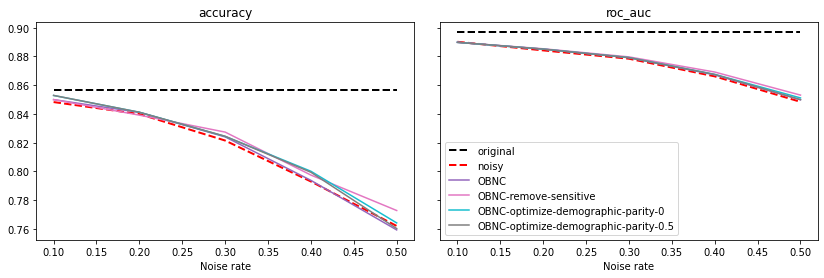

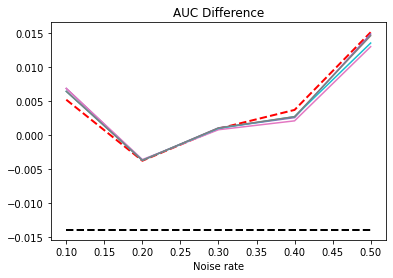

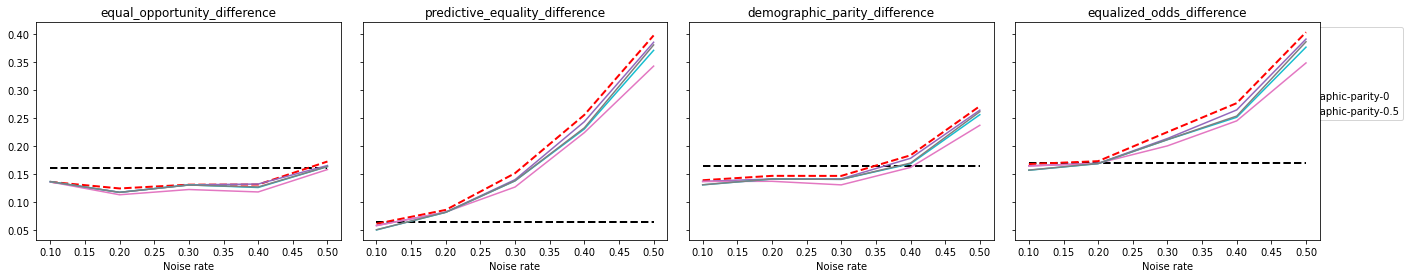

In [7]:
show_all_metrics_pred('bias', 'original', algorithms, experiments, runs, nr)
show_metric_aggregated('bias', 'original', 'auc_difference', plt.gca(), f'AUC Difference', algorithms, experiments, runs, nr)
show_all_metrics_fair('bias', 'original', algorithms, experiments, runs, nr)

## Balanced Bias

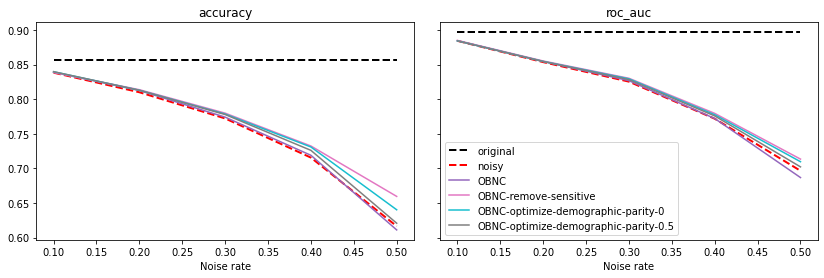

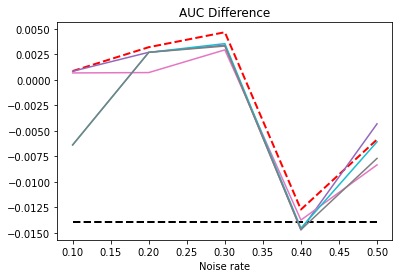

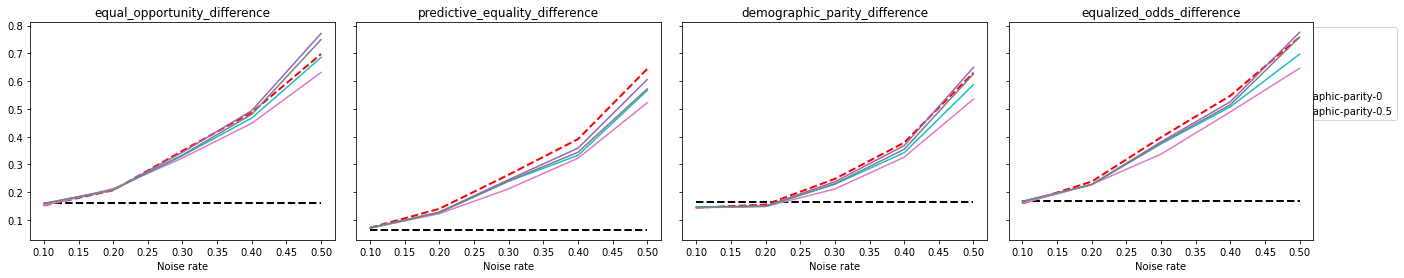

In [8]:
show_all_metrics_pred('balanced_bias', 'original', algorithms, experiments, runs, nr)
show_metric_aggregated('balanced_bias', 'original', 'auc_difference', plt.gca(), f'AUC Difference', algorithms, experiments, runs, nr)
show_all_metrics_fair('balanced_bias', 'original', algorithms, experiments, runs, nr)

# Error bars

## Random noise

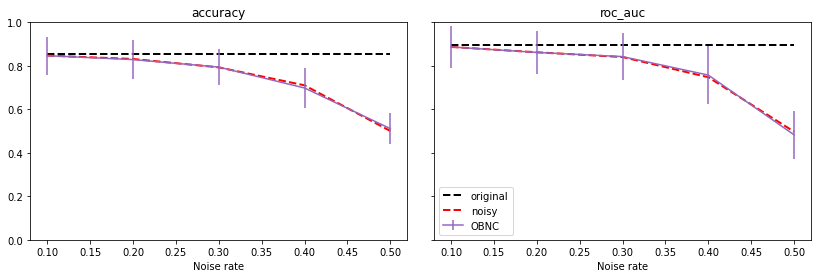

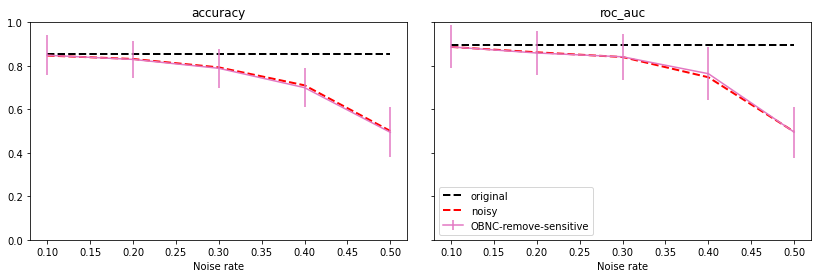

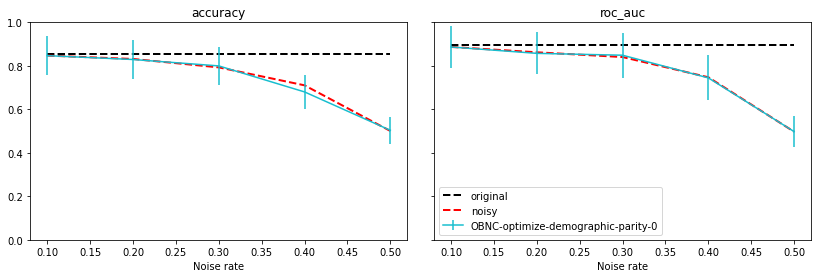

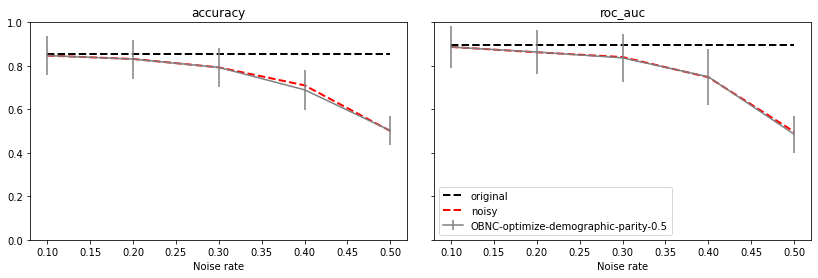

In [9]:
for alg in algorithms:
    show_all_metrics_pred('random', 'original', [alg], experiments, runs, nr, True)

## Label flipping

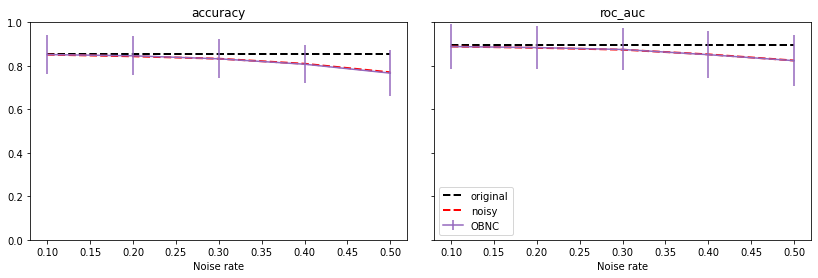

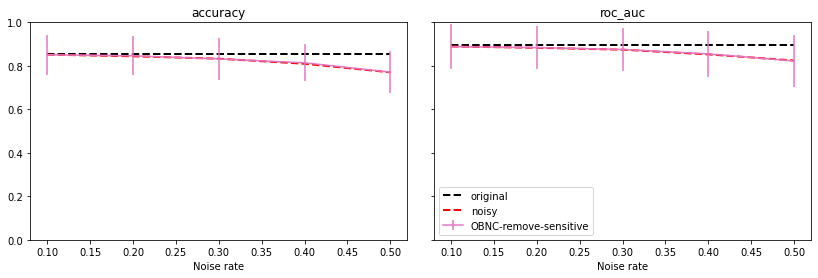

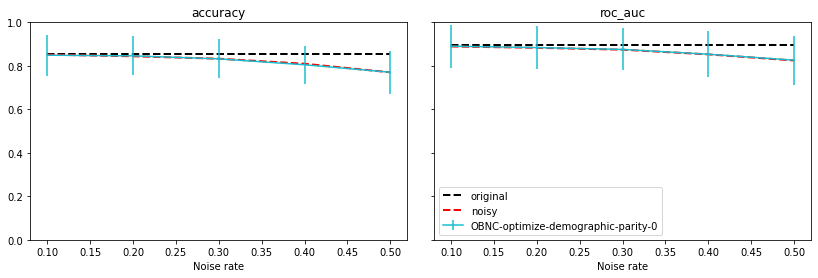

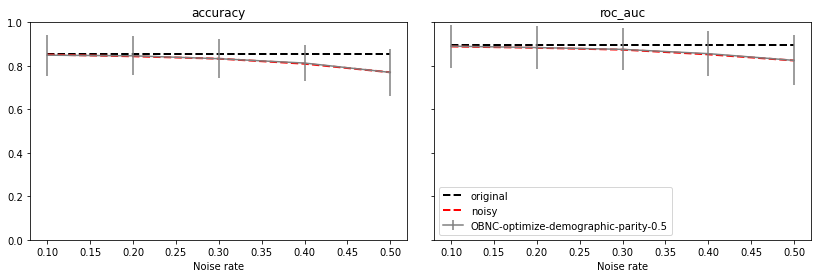

In [10]:
for alg in algorithms:
    show_all_metrics_pred('flip', 'original', [alg], experiments, runs, nr, True)

## Positive Bias

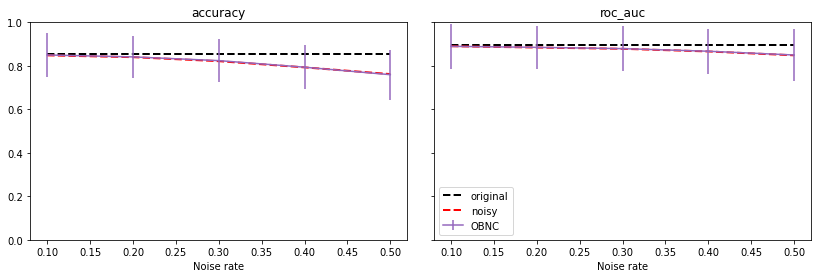

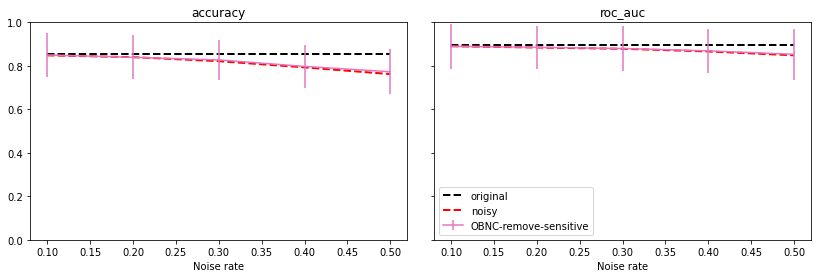

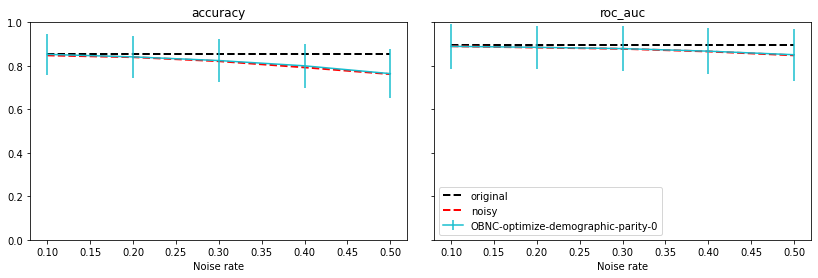

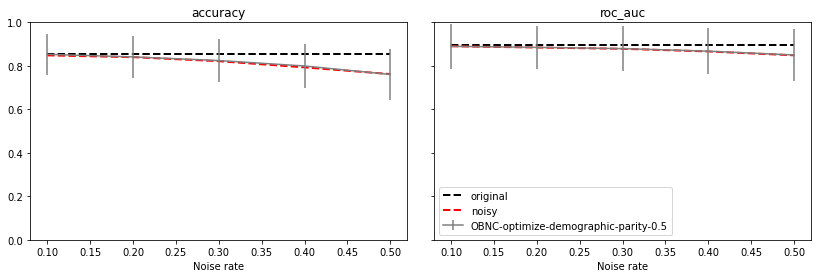

In [11]:
for alg in algorithms:
    show_all_metrics_pred('bias', 'original', [alg], experiments, runs, nr, True)

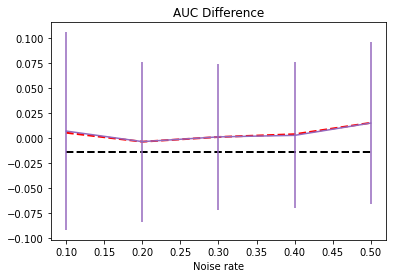

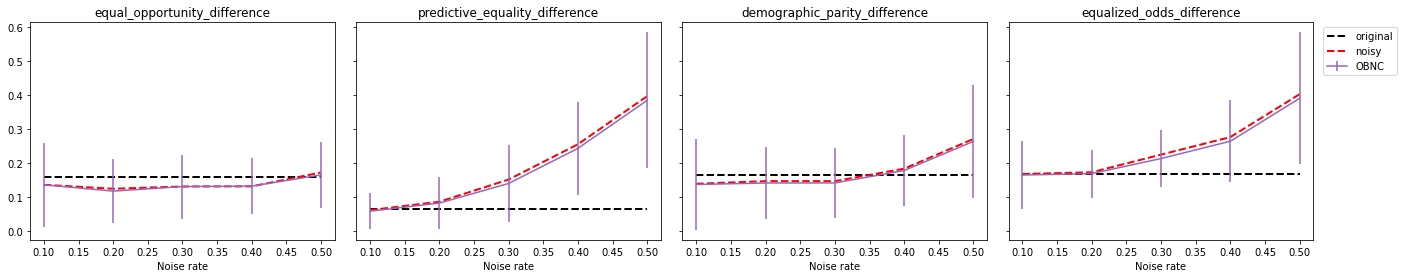

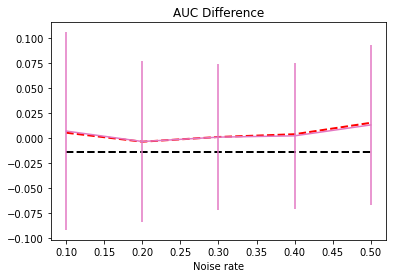

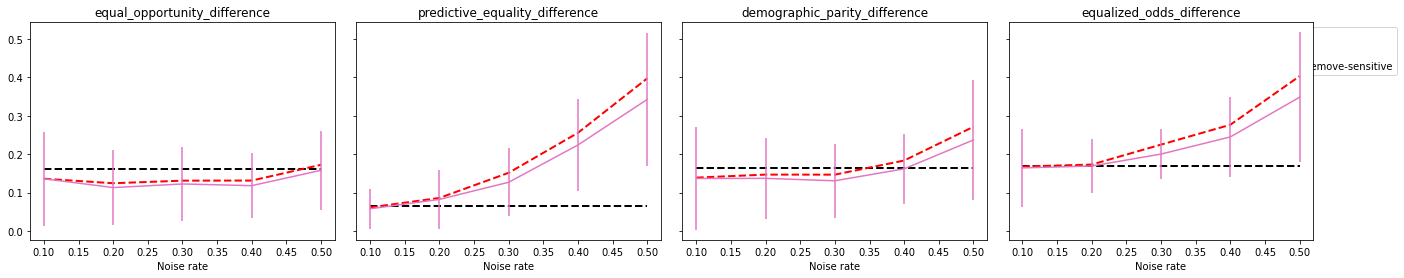

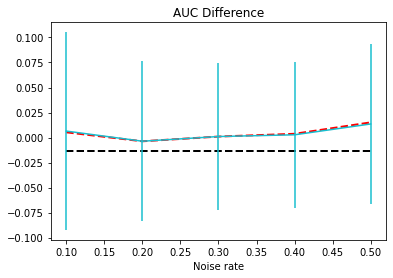

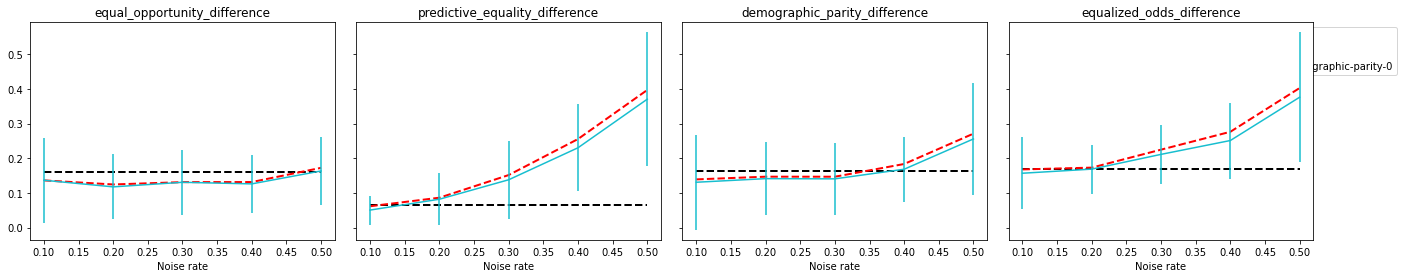

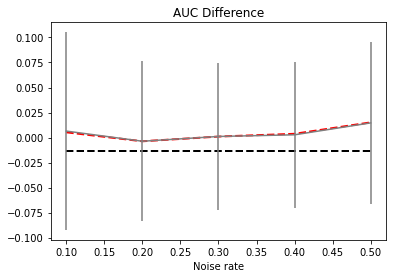

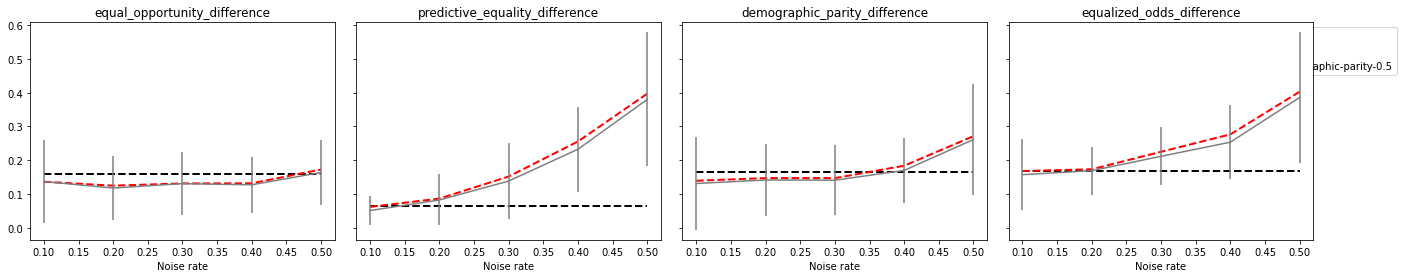

In [12]:
for alg in algorithms:
    show_metric_aggregated('bias', 'original', 'auc_difference', plt.gca(), f'AUC Difference', [alg], experiments, runs, nr)
    show_all_metrics_fair('bias', 'original', [alg], experiments, runs, nr)

## Balanced Bias

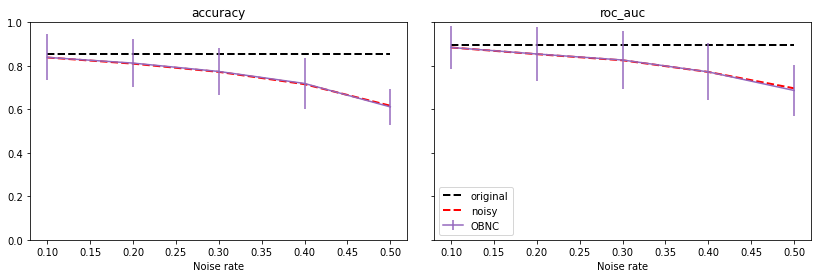

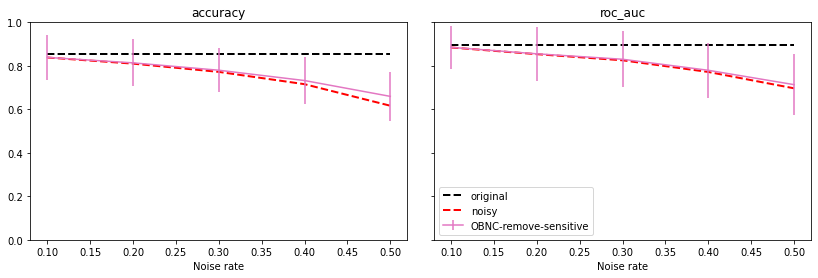

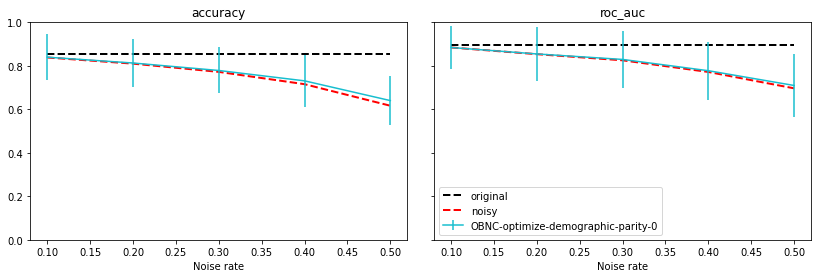

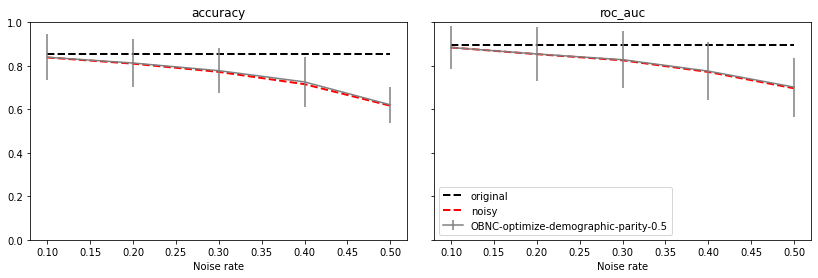

In [13]:
for alg in algorithms:
    show_all_metrics_pred('balanced_bias', 'original', [alg], experiments, runs, nr, True)

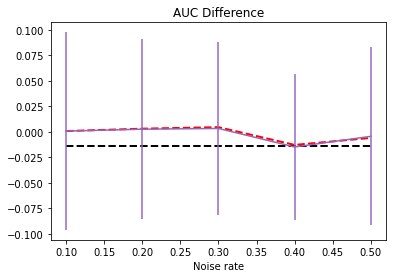

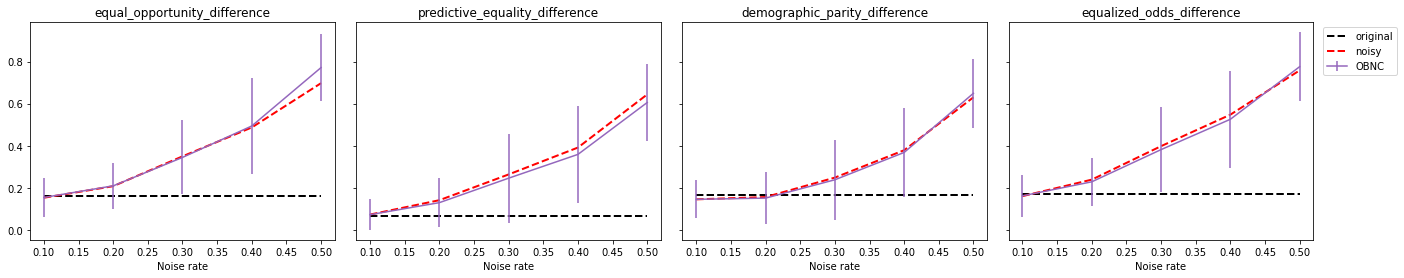

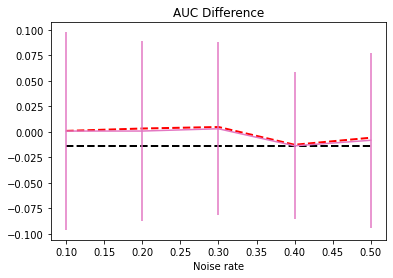

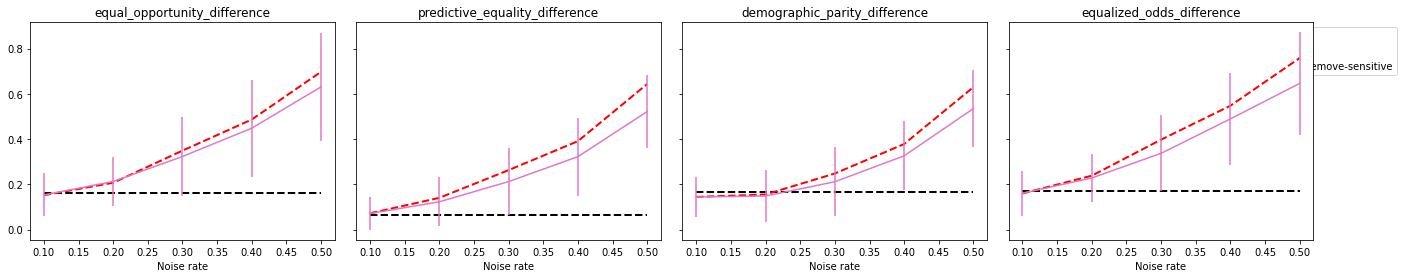

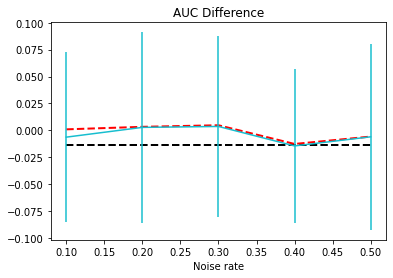

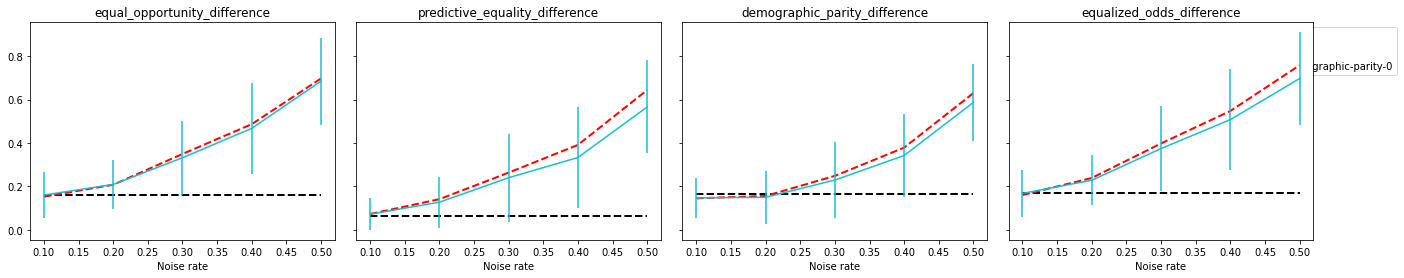

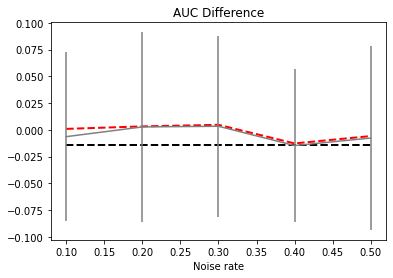

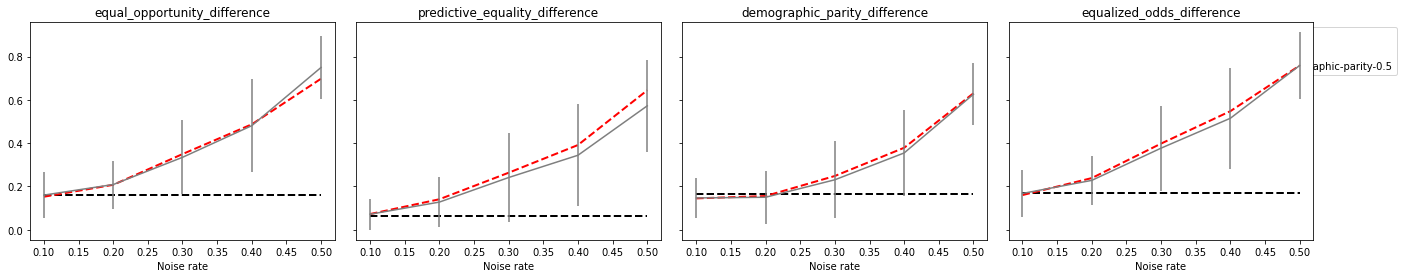

In [14]:
for alg in algorithms:
    show_metric_aggregated('balanced_bias', 'original', 'auc_difference', plt.gca(), f'AUC Difference', [alg], experiments, runs, nr)
    show_all_metrics_fair('balanced_bias', 'original', [alg], experiments, runs, nr)

In [15]:
colors = {
    'OBNC':'tab:purple', 
    'OBNC-remove-sensitive': 'tab:pink',
    'OBNC-optimize-demographic-parity-0': 'tab:cyan',
    'OBNC-optimize-demographic-parity-0.5': 'tab:gray',
}

In [16]:
import numpy as np

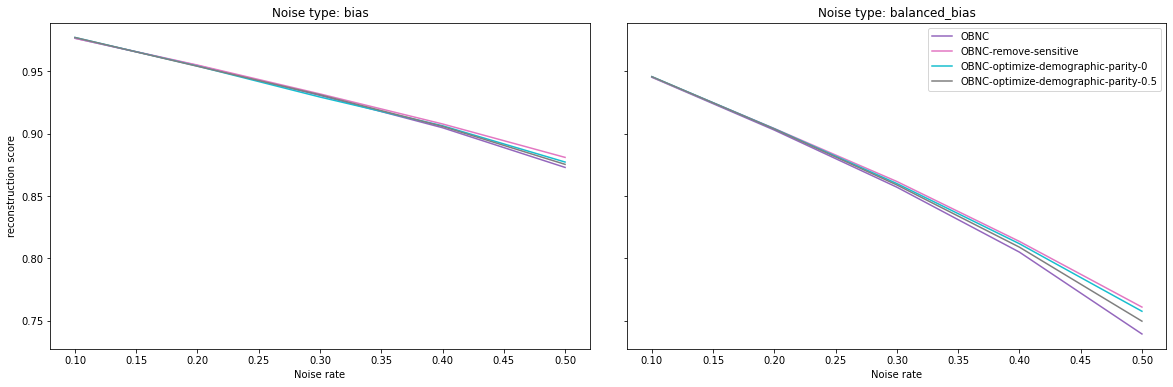

In [28]:
fig = plt.figure(figsize=(20, 6))
axs = fig.subplots(1, 2, sharey=True, sharex=True)

for i in range(2):
    ax = axs[i]
    
    for alg in algorithms:
        values = []
        for noise_rate in nr:
            avg_value = []
            for exp in experiments:
                if f'{exp}_{alg}' in runs[noise_types[i+2]]:
                    run = runs[noise_types[i+2]][f'{exp}_{alg}']
                    avg_value.append(run.loc[run['params.noise_rate'] == noise_rate][f'metrics.correction_acc'].mean())
            values.append(np.mean(avg_value))
        
        ax.plot(nr, values, label=alg, color=colors[alg])
    
    ax.set_xlabel('Noise rate')         
    if i == 0:
        ax.set_ylabel('reconstruction score')
    ax.set_title(f'Noise type: {noise_types[i+2]}')

y_pos = 1.01
ax.legend()
plt.subplots_adjust(wspace=0.07, hspace=0.15)
plt.show()

In [18]:
markers = {
    0: 'o',
    0.1: 's',
    0.2: 'v',
    0.3: 'D',
    0.4: 'P',
    0.5: 'p'
}

In [19]:
type_names = {
    'random': 'Random',
    'flip': 'Label Flipping',
    'bias': 'Positive Bias',
    'balanced_bias': 'Balanced bias'
}

In [20]:
alg_names = {
    'OBNC': 'Ordering-Based Noise Correction',
    'OBNC-remove-sensitive': 'Fair Ordering-Based Noise Correction (remove sensitive features)',
    'OBNC-optimize-demographic-parity-0': 'Fair Ordering-Based Noise Correction (optimize demographic parity, prob=0)',
    'OBNC-optimize-demographic-parity-0.5': 'Fair Ordering-Based Noise Correction (optimize demographic parity, prob=0.5)'
}

In [21]:
def trade_off_curve(alg, noise_type, test_set, nr, ax, noisy=False):
    predictive_performance = []
    fairness = []

    if test_set == 'original':
        pred_original = []
        fair_original = []

    for exp in experiments:
        run = runs[noise_type][f'{exp}_{alg}']
        run = run.loc[(run['tags.test_set'] == test_set) & (run['params.noise_rate'].isin(nr))]

        if noisy:
            train_set = 'noisy'
        else:
            train_set = 'corrected'

        predictive_performance.append(run.loc[(run['tags.train_set'] == train_set)].sort_values(by='params.noise_rate', ascending=True)['metrics.roc_auc'].values)
        fairness.append(run.loc[(run['tags.train_set'] == train_set)].sort_values(by='params.noise_rate', ascending=True)['metrics.predictive_equality_difference_0.5'].values)
        
        if test_set == 'original':
            pred_original.append(run.loc[(run['tags.train_set'] == 'original') & (run['params.noise_rate'] == 0.1)]['metrics.roc_auc'].values[0])
            fair_original.append(run.loc[(run['tags.train_set'] == 'original') & (run['params.noise_rate'] == 0.1)]['metrics.predictive_equality_difference_0.5'].values[0])
        
    if test_set == 'original':
        predictive_performance = [np.mean(pred_original)] + list(np.mean(np.array(predictive_performance), axis=0))
        fairness = [np.mean(fair_original)] + list(np.mean(np.array(fairness), axis=0))
    else:
        predictive_performance = list(np.mean(np.array(predictive_performance), axis=0))
        fairness = list(np.mean(np.array(fairness), axis=0))
    
    if test_set == 'original':
            nr = [0.0] + nr

    if noisy:
        ax.plot(fairness, predictive_performance, color='red', linestyle='--')
        for i in range(len(nr)):
            ax.scatter(fairness[i], predictive_performance[i], color='red', marker=markers[nr[i]], label=f'Noise rate = {nr[i]}')
    else:
        ax.plot(fairness, predictive_performance, color=colors[alg])
        for i in range(len(nr)):
            ax.scatter(fairness[i], predictive_performance[i], color=colors[alg], marker=markers[nr[i]])


In [22]:
def trade_off_separate_algs(noise_type, test_set, nr):
    fig = plt.figure(figsize=(15, 8))
    axs = fig.subplots(2, 2, sharey=True, sharex=True)

    for i in range(len(algorithms)):
        alg = algorithms[i]
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        trade_off_curve(alg, noise_type, test_set, nr, ax)
        trade_off_curve('OBNC', noise_type, test_set, nr, ax, noisy=True)
        
        if row == 2:
            ax.set_xlabel('Predictive Equality Difference')
        if col == 0:
            ax.set_ylabel('AUC')
        ax.set_title(alg_names[alg])

    axs[1,1].legend()
    plt.suptitle(f'Noise type: {type_names[noise_type]}', fontsize=16, y=1)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    plt.show()

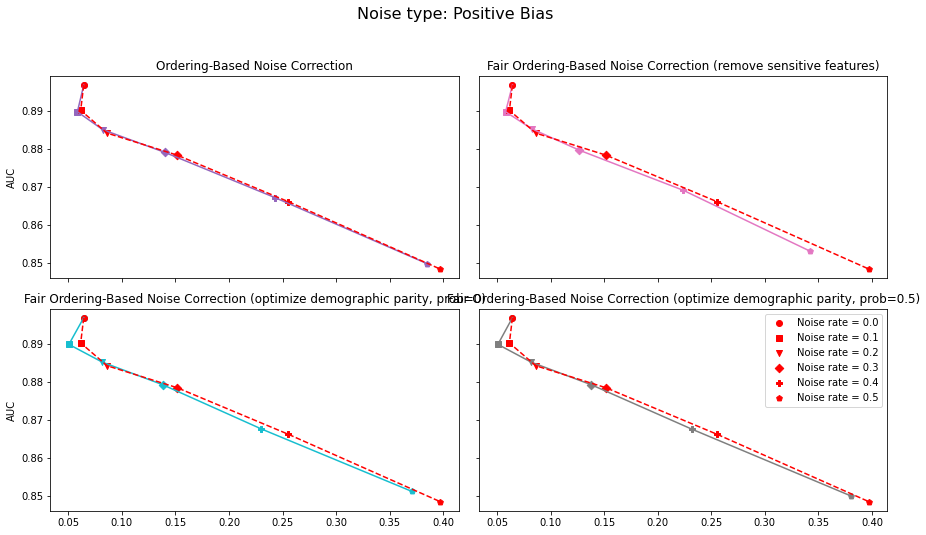

In [23]:
trade_off_separate_algs('bias', 'original', nr)

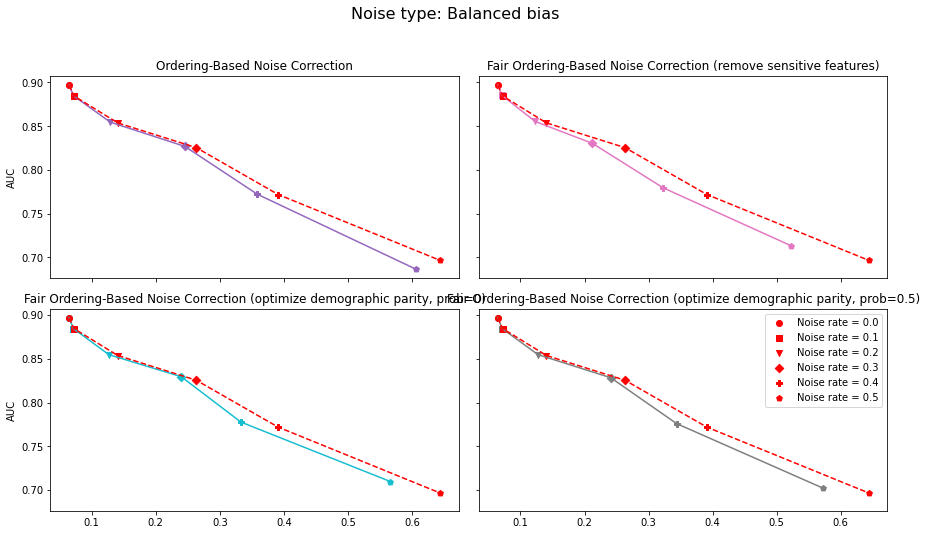

In [24]:
trade_off_separate_algs('balanced_bias', 'original', [i/10 for i in range(1, 6)])

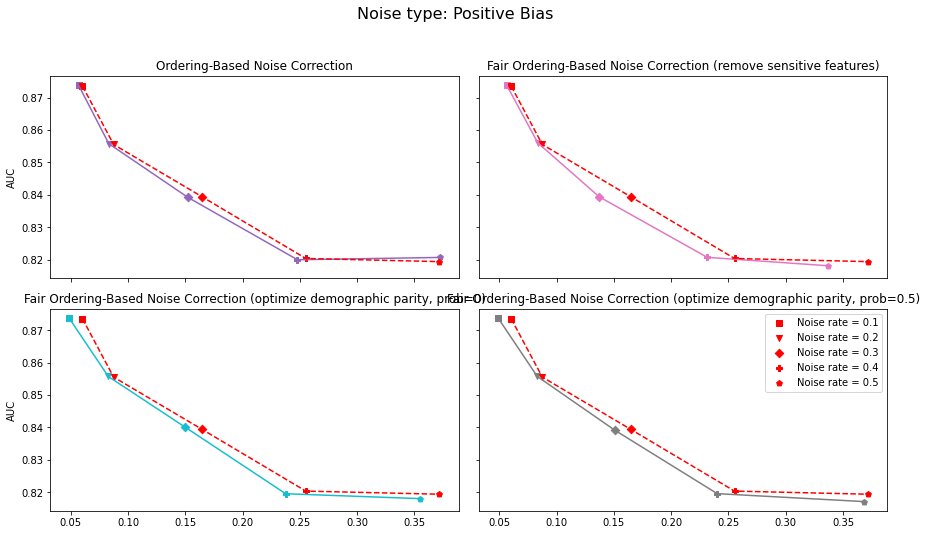

In [25]:
trade_off_separate_algs('bias', 'noisy', nr)

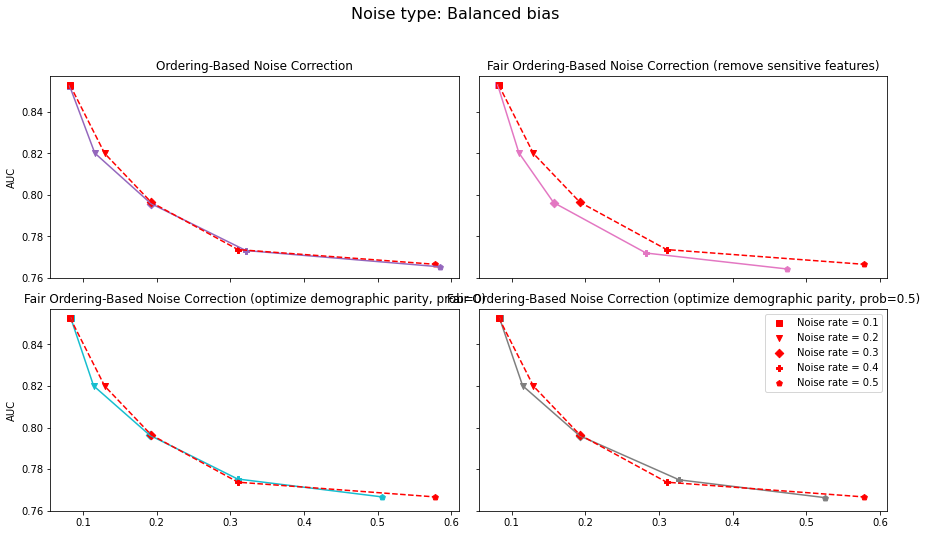

In [26]:
trade_off_separate_algs('balanced_bias', 'noisy', [i/10 for i in range(1, 6)])